In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from signals import *
from frequencyestimator import *
import time
import copy

sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})

<Figure size 640x480 with 0 Axes>

In [124]:
P0 = lambda n, theta: np.cos((2*n+1)*theta)**2
P1 = lambda n, theta: np.sin((2*n+1)*theta)**2

def estimate_signal(depths, n_samples, theta, eta=0.0):
        signals = np.zeros(len(depths))#, dtype = np.complex128)
        cos_signal = np.zeros(len(depths), dtype = np.complex128)
        for i,n in enumerate(depths):
            # Get the exact measuremnt probabilities
            p0 = P0(n, theta)
            p1 = P1(n, theta)

            p0x = P0x(n,theta)
            p1x = P1x(n,theta)

            # Get the "noisy" probabilities by sampling and adding a bias term that pushes towards 50/50 mixture
            eta_n = (1.0-eta)**(n+1) # The error at depth n increases as more queries are implemented
            p0_estimate = np.random.binomial(n_samples[i], eta_n*p0 + (1.0-eta_n)*0.5)/n_samples[i]
            p1_estimate = 1 - p0_estimate
            # p1_estimate = np.random.binomial(n_samples[i], eta_n*p1 + (1.0-eta_n)*0.5)/n_samples[i]
            p0x_estimate = np.random.binomial(n_samples[i], eta_n*p0x + (1.0-eta_n)*0.5)/n_samples[i]
            p1x_estimate = 1.0 - p0x_estimate
            
            # Estimate theta
            theta_estimated = np.arctan2(p0x_estimate - p1x_estimate, p0_estimate - p1_estimate)

            # estimate cos(2n+1)2theta
            # cos_signal[i] = p0_estimate - p1_estimate
            
            # Store this to determine angle at theta = 0 or pi/2
            if i==0:
                p0mp1 = p0_estimate - p1_estimate

            # Compute f(n) - Eq. 3
            # fi_estimate = np.exp(1.0j*theta_estimated)
            # fi_estimate = 2*p0_estimate - 1 + 1.0j*np.sqrt(1-(2*p0_estimate - 1)**2)
            # fi_estimate = 2*p0_estimate - 1
            # fi_estimate = np.cos((2*n+1)*2*theta)
            # fi_estimate = np.exp(1.0j*(2*n+1)*2*theta)
            fi_estimate = 2*p0 - 1 + np.random.normal(0.0, 1/n_samples[i])

            # signals[i] = np.real(fi_estimate)
            signals[i] = fi_estimate
         
        return signals    

# Signal estimates on linear array

Use fft to find the angles when sampling the cosine on a linear array (so depths 0,1,2,3,4.., 1000 for example).
Theoretically this should give the correct peaks.
Also use ESPIRIT to find the peaks.

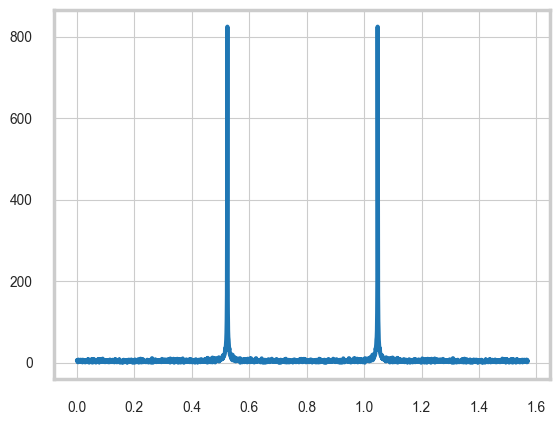

In [125]:
# Set the actual amplitude
theta = np.pi/6

theta1 = np.pi/5
theta2 = -theta1

depths = [i for i in range(2000)]
n_samples = [10 for d in depths]

R = estimate_signal(depths, n_samples, theta)

# R = [0.5*np.exp(1j*theta1*(2*d+1)) + 0.5*np.exp(1j*theta2*(2*d+1)) for d in depths]

fft = np.abs(np.fft.fft(R))

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

In [65]:
# amax = np.argmax(fft[:len(fft)//2])
amax = np.argmax(fft)
print(f'theta: {theta}')
print('peaks:', np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)))

theta: 0.5235987755982988
peaks: 0.523860574986098 1.0469357518087987


In [66]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/4}')
print(f'theta_est: {theta_est}')
print(f'theta: {theta}')
np.sum(np.abs(angle))/8

angles: [-0.52386137  0.52386137]
theta_est: 0.5238613720505535
theta: 0.5235987755982988


0.5238613720505535

## Get the real signal values on virtual locations 
One can do this using Chebyshev polynomials with the recurrence $\cos(nx) = 2\cos(x)\cos((n-1)x) - \cos((n-2)x)$

[0.3091371]
0.32404616978068135


(0.9456193887305278, 0.6251769380643689, 0.6283185307179586)

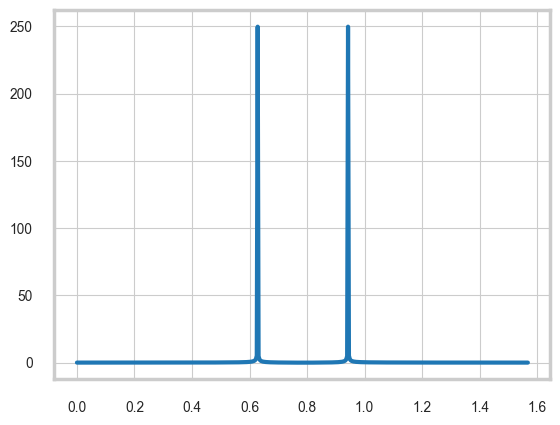

In [159]:
from scipy.special import chebyt, chebyu

def get_cheb_vals(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
        R[n] = chebyt(2*n+1)(np.cos(w))
    return R

def get_cosine_values(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
         R[n] = np.cos((2*n+1)*w)
    return R

# For reproducibility
# np.random.seed(8)

theta = np.pi/5
w = 2*theta

# depths = [0] + [2**i for i in range(6)]
depths = [0]
# n_samples = [(d_max - d)//2 + 1 for d in depths]
n_samples = [400 for _ in depths]

R = estimate_signal(depths, n_samples, theta)
print(R)
S = np.cos(w) + np.random.normal(0.0,1/100)
print(S)
vR = [chebyt(2*n+1)(R[0]) for n in range(500)]
R = vR
# R = get_cheb_vals(d_max, w)
# R = get_cosine_values(d_max, w)

fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[1:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)), theta

In [160]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/2}')
print(f'theta_est: {2*theta_est}')
print(f'w: {w}')
np.sum(np.abs(angle))/4

angles: [ 1.25903098 -1.25903098]
theta_est: 1.882561675995292
w: 1.2566370614359172


1.259030977594501

This seems to work: Sample at depth 0 to get an approximation of $T_1(\cos(\omega)) = \cos(\omega)$ and use Chebyshev polynomials to get $T_{2n+1}(\cos(\omega)) = \cos((2n+1)\omega)$ and use ESPRIT or FFT.

Unfortunately, the scaling in this case is no better than classical since $|T_n(\cos(\omega)) - T_n(x)|< n\epsilon$ if $x = \cos(\omega)+\epsilon$ ($x$ being a noisy version of $\cos(\omega)$).

In [154]:
[2**k + 1 for k in range(1,9)]

[3, 5, 9, 17, 33, 65, 129, 257]

depths:[0, 1, 2, 4, 8, 16, 32]
idx_vals:[1, 3, 5, 9, 17, 33, 65]
{1: 0.30901699437494745, 3: -0.8090169943749475, 5: 1.0, 9: 0.309016994374947, 17: -0.8090169943749469, 33: -0.8090169943749483, 65: 1.0}
64


(0.9326603190344698, 0.6381360077604268, 0.6283185307179586)

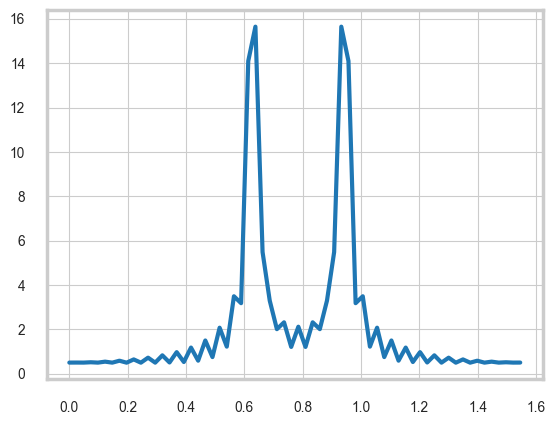

In [87]:
theta = np.pi/5# np.arccos(a)
w = 2*theta

q=6

depths = [0] + [2**i for i in range(q)]
n_samples = [100 for _ in depths]
print(f'depths:{depths}')

idx = [0]*

S = estimate_signal(depths, n_samples, theta)



fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.pi*(len(fft)-amax)/(2*len(fft)) , np.pi*(amax)/(2*len(fft)), theta

In [9]:
R = R[:len(R)//2]
len(R)

256

In [10]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle}')
print(f'w: {w}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')
np.sum(np.abs(angle))/4

angles: [ 2.41720381 -2.41720381]
w: 2.0943951023931953
theta_est: 0.9664953736318308
theta:1.0471975511965976


1.2086019063261315

In [41]:
theta = np.pi/5
w = 2*theta
depths = [d for d in range(4000)]
n_samples = [10 for d in depths]
complex_signal = estimate_signal(depths=depths, n_samples=n_samples, theta=theta)

espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(complex_signal)
print(f'angles: {angle}')
print(f'w: {w}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')

angles: [-2.51423504 -2.51474992]
w: 1.2566370614359172
theta_est: 0.6285587590036431
theta:0.6283185307179586


In [4]:
1-0.707**(1/20)

0.017186822842938265

In [41]:
N = 10
s = np.random.normal(0.0, 1/N, 1000)
np.std(s)

0.09935027704402889

In [48]:
theta = np.pi/5

e1 = np.random.normal(0.0, 1/N, 10000)
e2 = 4*np.cos(theta)*e1 + 2*e1**2

e3 = np.random.normal(0.0, 1/N, 10000)
e4 = 2*(e3*np.cos(theta) + e1*np.cos(3*theta) + e1*e2) + e2

np.mean(e1), np.mean(e2), np.mean(e3), np.mean(e4)



(0.0005434237717080098,
 0.021278568013089985,
 -9.922750879682882e-05,
 0.08411367535132946)

In [49]:
np.std(e1), np.std(e2), np.std(e3), np.std(e4)

(0.09879124740700014,
 0.32162763499706853,
 0.1002516082888583,
 0.34041473501114483)

In [50]:
np.sqrt(1/7)

0.3779644730092272

We need to solve the sign ambiguity at each depth. Consider the following approach.

Suppose we know $\cos(\omega)$, this implies $\sin(\omega) = \pm \sqrt{1-\cos^2(\omega)}$.

Choose a sign, say $+$. Then we form the exponential $e^{i\omega} = \cos(\omega) + i\sin(\omega)$.

Next we obtain $\cos(3\omega)$ as well and also choose $+$ for the sign, so we have $e^{i3\omega} = \cos(3\omega) + i\sin(3\omega)$.

Then, knowing $\cos(5\omega)$ determines if the chosen signs are consistent.

In [531]:
std = 1/10**3

w = np.pi/2.75

cos1 = np.cos(w) + np.random.normal(0.0, std)
sin1 = np.sqrt(1-cos1**2)

cos3 = np.cos(3*w) + np.random.normal(0.0, std)
sin3 = np.sqrt(1-cos3**2)

cos5 = np.cos(5*w) + np.random.normal(0.0, std)
sin5 = np.sqrt(1-cos5**2)

print(np.isclose(cos5, np.real((cos1+1.0j*sin1)**2*(cos3-1.0j*sin3)), rtol=0.01))

cos9 = np.cos(9*w) + np.random.normal(0.0, std)

print(np.isclose(cos9, np.real((cos1+1.0j*sin1) * (cos3-1.0j*sin3) * (cos5-1.0j*sin5)), rtol=0.01))

True
True


In [456]:
np.random.normal(0.0, 1/100)

-0.0016079225217413928

In [475]:
5*w % 2*np.pi

3.5864190939097718

In [494]:
np.pi/2.5 % 2*np.pi

3.947841760435743

In [495]:
np.pi/2.5

1.2566370614359172